## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
columns = [
    "unit_number",
    "cycle",
    "op_setting_1",
    "op_setting_2",
    "op_setting_3",
    "sensor_1",
    "sensor_2",
    "sensor_3",
    "sensor_4",
    "sensor_5",
    "sensor_6",
    "sensor_7",
    "sensor_8",
    "sensor_9",
    "sensor_10",
    "sensor_11",
    "sensor_12",
    "sensor_13",
    "sensor_14",
    "sensor_15",
    "sensor_16",
    "sensor_17",
    "sensor_18",
    "sensor_19",
    "sensor_20",
    "sensor_21",
]


In [3]:
train_path = "train_FD001.txt"
df_train = pd.read_csv(train_path, sep='\s+', header=None, names=columns)

In [4]:
test_path = "test_FD001.txt"
df_test = pd.read_csv(test_path, sep='\s+', header=None, names=columns)

In [5]:
rul_path = "RUL_FD001.txt"
df_rul = pd.read_csv(rul_path, sep='\s+', header=None, names=["RUL"])

## Exploratory Data Analysis

In [6]:
print(df_train.shape)
print(df_test.shape)

(20631, 26)
(13096, 26)


In [7]:
df_train.isnull().sum()

unit_number     0
cycle           0
op_setting_1    0
op_setting_2    0
op_setting_3    0
sensor_1        0
sensor_2        0
sensor_3        0
sensor_4        0
sensor_5        0
sensor_6        0
sensor_7        0
sensor_8        0
sensor_9        0
sensor_10       0
sensor_11       0
sensor_12       0
sensor_13       0
sensor_14       0
sensor_15       0
sensor_16       0
sensor_17       0
sensor_18       0
sensor_19       0
sensor_20       0
sensor_21       0
dtype: int64

In [8]:
max_cycles = df_train.groupby("unit_number")["cycle"].max()

df_train["RUL"] = df_train.apply(
    lambda row: max_cycles[row["unit_number"]] - row["cycle"],
    axis=1
)

In [9]:
df_train.describe()

,unit_number,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000


In [10]:
df_train["unit_number"].nunique()

100

In [11]:
# Cycles per engine
engine_cycles = df_train.groupby("unit_number")["cycle"].max()

engine_cycles.describe()

count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: cycle, dtype: float64

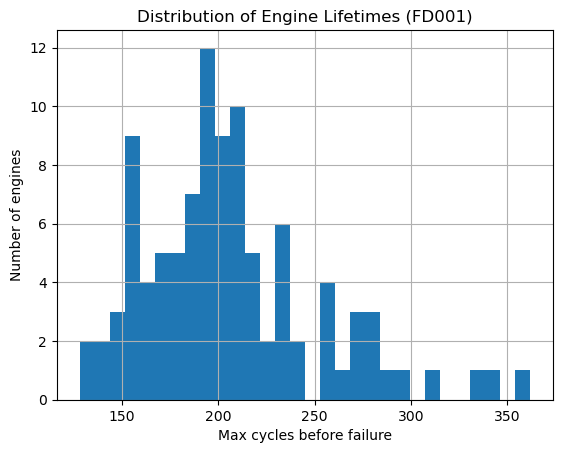

In [12]:
plt.figure()
engine_cycles.hist(bins=30)
plt.xlabel("Max cycles before failure")
plt.ylabel("Number of engines")
plt.title("Distribution of Engine Lifetimes (FD001)")
plt.show()

### RUL Analysis

In [13]:
df_train["RUL"].describe()

count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

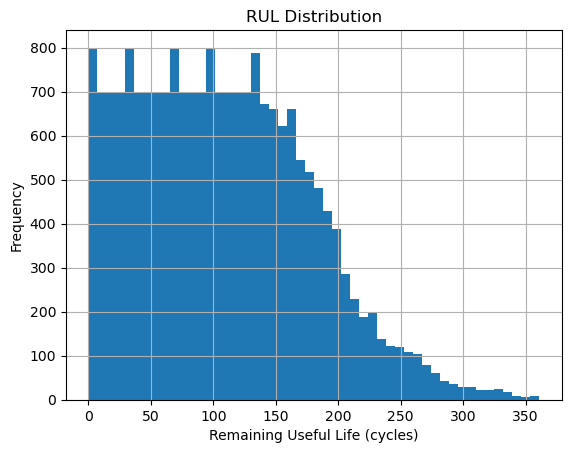

In [14]:
plt.figure()
df_train["RUL"].hist(bins=50)
plt.xlabel("Remaining Useful Life (cycles)")
plt.ylabel("Frequency")
plt.title("RUL Distribution")
plt.show()

### RUL vs Cycle

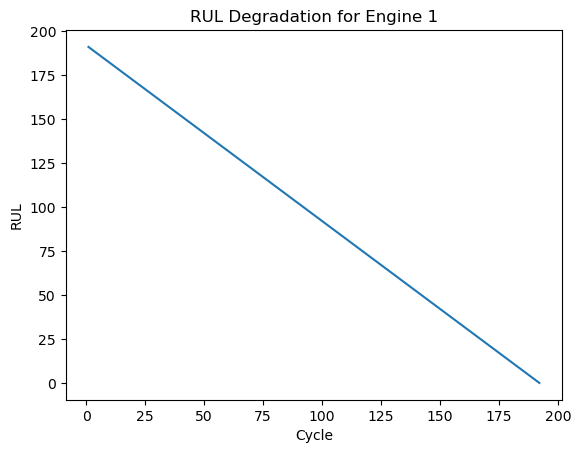

In [15]:
sample_engine = df_train["unit_number"].iloc[0]

engine_df = df_train[df_train["unit_number"] == sample_engine]

plt.figure()
plt.plot(engine_df["cycle"], engine_df["RUL"])
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title(f"RUL Degradation for Engine {sample_engine}")
plt.show()

### Operational Settings Analysis

In [16]:
op_cols = ["op_setting_1", "op_setting_2", "op_setting_3"]

df_train[op_cols].describe()

,op_setting_1,op_setting_2,op_setting_3
count,20631.000000,20631.000000,20631.0
mean,-0.000009,0.000002,100.0
std,0.002187,0.000293,0.0
min,-0.008700,-0.000600,100.0
25%,-0.001500,-0.000200,100.0
50%,0.000000,0.000000,100.0
75%,0.001500,0.000300,100.0
max,0.008700,0.000600,100.0


<Figure size 640x480 with 0 Axes>

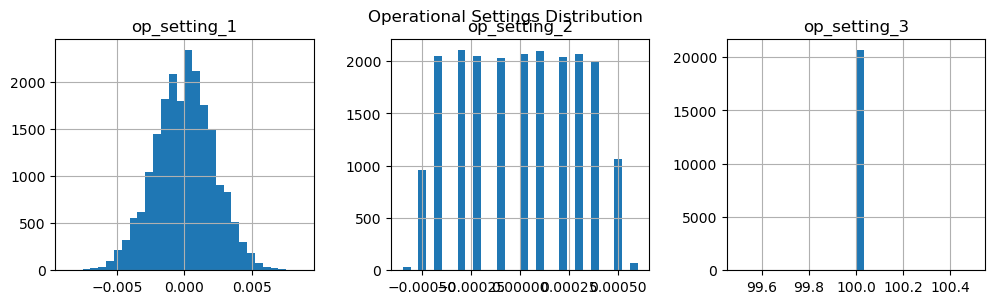

In [18]:
plt.figure()
df_train[op_cols].hist(bins=30, layout=(1, 3), figsize=(12, 3))
plt.suptitle("Operational Settings Distribution")
plt.show()

### Sensor variance analysis

In [19]:
sensor_cols = [col for col in df_train.columns if col.startswith("sensor_")]

sensor_std = df_train[sensor_cols].std().sort_values()

sensor_std

sensor_19    0.000000e+00
sensor_18    0.000000e+00
sensor_16    1.556432e-14
sensor_10    4.660829e-13
sensor_5     3.394700e-12
sensor_1     6.537152e-11
sensor_6     1.388985e-03
sensor_15    3.750504e-02
sensor_8     7.098548e-02
sensor_13    7.191892e-02
sensor_21    1.082509e-01
sensor_20    1.807464e-01
sensor_11    2.670874e-01
sensor_2     5.000533e-01
sensor_12    7.375534e-01
sensor_7     8.850923e-01
sensor_17    1.548763e+00
sensor_3     6.131150e+00
sensor_4     9.000605e+00
sensor_14    1.907618e+01
sensor_9     2.208288e+01
dtype: float64

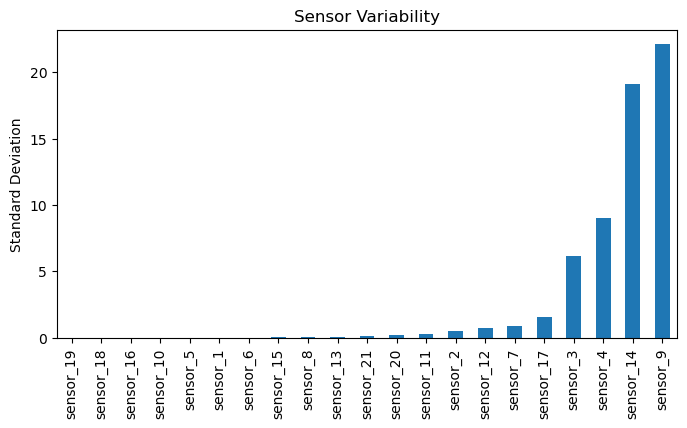

In [20]:
plt.figure(figsize=(8, 4))
sensor_std.plot(kind="bar")
plt.ylabel("Standard Deviation")
plt.title("Sensor Variability")
plt.show()

### Sensor Degradation Trends

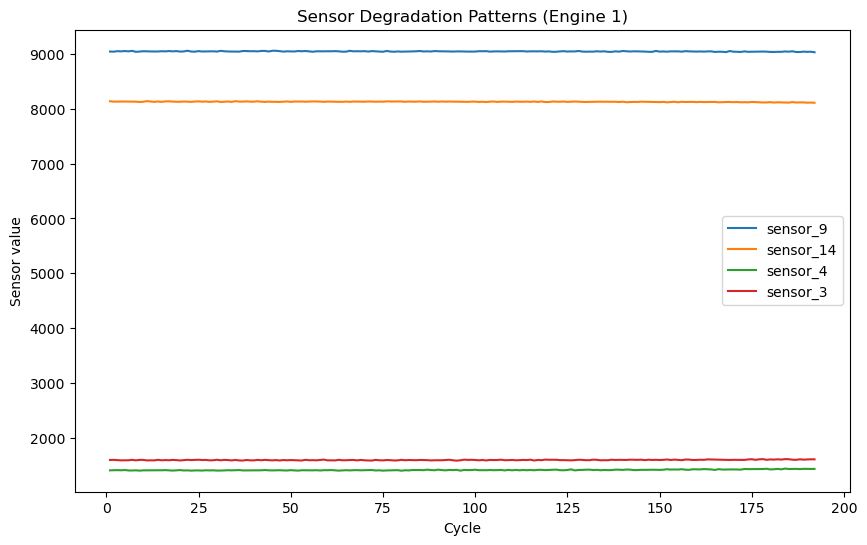

In [21]:
important_sensors = ["sensor_9", "sensor_14", "sensor_4", "sensor_3"]

engine_df = df_train[df_train["unit_number"] == sample_engine]

plt.figure(figsize=(10, 6))
for s in important_sensors:
    plt.plot(engine_df["cycle"], engine_df[s], label=s)

plt.xlabel("Cycle")
plt.ylabel("Sensor value")
plt.title(f"Sensor Degradation Patterns (Engine {sample_engine})")
plt.legend()
plt.show()

### Correlation with RUL

In [22]:
corr = df_train[sensor_cols + ["RUL"]].corr()["RUL"].sort_values()

corr

sensor_11   -0.696228
sensor_4    -0.678948
sensor_15   -0.642667
sensor_2    -0.606484
sensor_17   -0.606154
sensor_3    -0.584520
sensor_8    -0.563968
sensor_13   -0.562569
sensor_9    -0.390102
sensor_14   -0.306769
sensor_6    -0.128348
sensor_20    0.629428
sensor_21    0.635662
sensor_7     0.657223
sensor_12    0.671983
RUL          1.000000
sensor_1          NaN
sensor_5          NaN
sensor_10         NaN
sensor_16         NaN
sensor_18         NaN
sensor_19         NaN
Name: RUL, dtype: float64

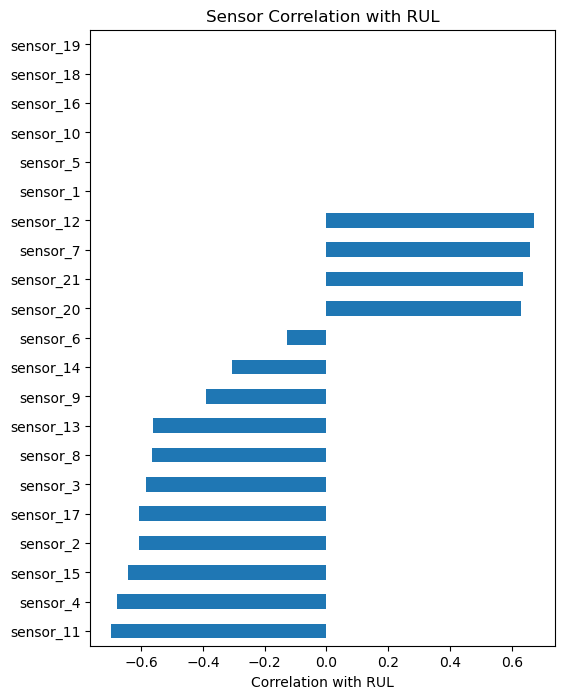

In [23]:
plt.figure(figsize=(6, 8))
corr.drop("RUL").plot(kind="barh")
plt.xlabel("Correlation with RUL")
plt.title("Sensor Correlation with RUL")
plt.show()

### Pairwise Trends

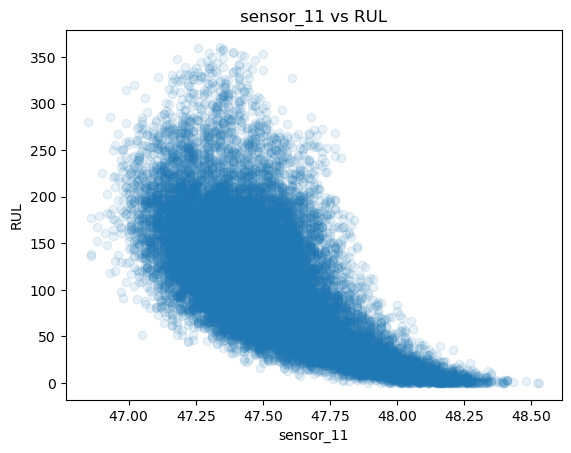

In [24]:
plt.figure()
plt.scatter(df_train["sensor_11"], df_train["RUL"], alpha=0.1)
plt.xlabel("sensor_11")
plt.ylabel("RUL")
plt.title("sensor_11 vs RUL")
plt.show()

### EDA Summary

- The FD001 dataset contains 100 engines operating under a single condition (sea-level) and a single fault mode. Engine lifetimes vary from 128 to 362 cycles, reflecting normal manufacturing variability.

- Three operational settings are provided: op_setting_1 and op_setting_2 show very small variance, while op_setting_3 is constant. These settings have limited predictive value and will be largely ignored in modeling.

- Sensor variability analysis shows that several sensors (sensor_1, sensor_5, sensor_10, sensor_16, sensor_18, sensor_19) have near-zero variance and were excluded from further analysis.

- High-variance sensors (sensor_9, sensor_14, sensor_4, sensor_3, sensor_17) exhibit clear degradation trends over time, making them strong predictors for Remaining Useful Life (RUL).

- Correlation analysis with RUL highlights both positively and negatively correlated sensors, confirming that some sensor signals increase while others decrease as the engine approaches failure. This suggests that non-linear models may better capture complex degradation patterns.

Overall, the data is clean, RUL labels are consistent, and sensors with meaningful signals are identified. These findings support feature selection and motivate the use of both tree-based machine learning models and deep learning models for RUL prediction.

## Feature Engineering

In [25]:
# Remove low variance sensors
sensor_cols = [col for col in df_train.columns if col.startswith("sensor_")]
sensor_std = df_train[sensor_cols].std()
low_variance_sensors = sensor_std[sensor_std < 1e-3].index.tolist()

df_train.drop(columns=low_variance_sensors, inplace=True)
df_test.drop(columns=low_variance_sensors, inplace=True)
sensor_cols = [col for col in sensor_cols if col not in low_variance_sensors]

In [26]:
# Compute max cycles for each test unit
test_max_cycles = df_test.groupby("unit_number")["cycle"].max()
df_test["max_cycle"] = df_test["unit_number"].map(test_max_cycles)

# Map RUL from labels
df_test["RUL"] = df_rul["RUL"] + df_test.groupby("unit_number")["cycle"].transform('max') - df_test["cycle"]

In [27]:
feature_cols = ["cycle"] + sensor_cols

# Normalize sensor columns
scaler = MinMaxScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

In [28]:
# Remove all operational settings
op_cols = [col for col in df_train.columns if col.startswith("op_setting_")]
df_train.drop(columns=op_cols, inplace=True)
df_test.drop(columns=op_cols, inplace=True)

In [29]:
# Train/validation split by engine
engines = df_train["unit_number"].unique()
train_units, val_units = train_test_split(engines, test_size=0.2, random_state=42)

train_df = df_train[df_train["unit_number"].isin(train_units)]
val_df = df_train[df_train["unit_number"].isin(val_units)]

In [30]:
feature_cols = [col for col in df_train.columns if col.startswith("sensor_") or col=="cycle"]
X_train = train_df[feature_cols]
y_train = train_df["RUL"]
X_val = val_df[feature_cols]
y_val = val_df["RUL"]

## Train models
### Random Forest

In [31]:
rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
mae_rf = mean_absolute_error(y_val, y_pred_rf)

print(f"Random Forest - RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}")

Random Forest - RMSE: 31.47, MAE: 23.93


### XGBoost

In [32]:
xgb = XGBRegressor(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    objective="reg:squarederror", random_state=42, n_jobs=-1
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

print(f"XGBoost - RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}")

XGBoost - RMSE: 32.07, MAE: 24.24


### Simple MLP with PyTorch

In [33]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

model = MLPRegressor(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [35]:
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
    
    # validation RMSE
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        val_loss = torch.sqrt(criterion(val_preds, y_val_tensor))
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Validation RMSE: {val_loss.item():.2f}")

Epoch 10/50, Validation RMSE: 29.68
Epoch 20/50, Validation RMSE: 28.47
Epoch 30/50, Validation RMSE: 28.76
Epoch 40/50, Validation RMSE: 28.83
Epoch 50/50, Validation RMSE: 29.24


In [36]:
# Final MLP evaluation
model.eval()
with torch.no_grad():
    y_pred_mlp = model(X_val_tensor).cpu().numpy()
rmse_mlp = np.sqrt(mean_squared_error(y_val, y_pred_mlp))
mae_mlp = mean_absolute_error(y_val, y_pred_mlp)

print(f"MLP - RMSE: {rmse_mlp:.2f}, MAE: {mae_mlp:.2f}")

MLP - RMSE: 29.24, MAE: 22.73


### LSTM

In [37]:
WINDOW_SIZE = 30  # number of previous cycles to look back

sensor_cols = [col for col in df_train.columns if col.startswith("sensor_")] + ["cycle"]

def create_sequences(df, window_size):
    sequences = []
    targets = []

    for engine in df["unit_number"].unique():
        engine_data = df[df["unit_number"] == engine].sort_values("cycle")
        data_array = engine_data[sensor_cols].values
        rul_array = engine_data["RUL"].values

        for i in range(len(data_array) - window_size):
            seq = data_array[i:i+window_size]
            target = rul_array[i + window_size]
            sequences.append(seq)
            targets.append(target)

    return np.array(sequences), np.array(targets)

X_train_seq, y_train_seq = create_sequences(train_df, WINDOW_SIZE)
X_val_seq, y_val_seq = create_sequences(val_df, WINDOW_SIZE)

In [38]:
# Convert to PyTorch tensors
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).unsqueeze(1).to(device)

X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32).unsqueeze(1).to(device)

In [39]:
# LSTM Dataset
class RULDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RULDataset(X_train_tensor, y_train_tensor)
val_dataset = RULDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [40]:
# LSTM Model
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # take last time step
        out = lstm_out[:, -1, :]
        return self.fc(out)

model = LSTMRegressor(input_dim=X_train_seq.shape[2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [41]:
# Training loop
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Train RMSE: {np.sqrt(np.mean(train_losses)):.2f}, "
              f"Val RMSE: {np.sqrt(np.mean(val_losses)):.2f}")

Epoch 10/50 - Train RMSE: 33.24, Val RMSE: 24.13
Epoch 20/50 - Train RMSE: 30.30, Val RMSE: 26.08
Epoch 30/50 - Train RMSE: 29.00, Val RMSE: 24.91
Epoch 40/50 - Train RMSE: 27.02, Val RMSE: 26.01
Epoch 50/50 - Train RMSE: 24.06, Val RMSE: 28.89


In [42]:
# Final LSTM evaluation
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_tensor).cpu().numpy()
rmse_val = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
mae_val = mean_absolute_error(y_val_seq, y_val_pred)

print(f"LSTM Validation - RMSE: {rmse_val:.2f}, MAE: {mae_val:.2f}")

LSTM Validation - RMSE: 29.09, MAE: 20.16


## LSTM Hyperparameter Tuning

In [43]:
# Add dropout for model
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        return self.fc(out)

In [44]:
hidden_sizes = [64, 128]
dropouts = [0.0, 0.2]
learning_rates = [0.001, 0.0005]

hyperparams = list(itertools.product(hidden_sizes, dropouts, learning_rates))
results = []

In [45]:
# Training loop
EPOCHS = 30

for hs, dp, lr in hyperparams:
    print(f"Training LSTM with hidden_size={hs}, dropout={dp}, lr={lr}")
    model = LSTMRegressor(input_dim=X_train_tensor.shape[2],
                          hidden_dim=hs, dropout=dp).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Train
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()


    # Validate
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor).cpu().numpy()
    rmse = np.sqrt(mean_squared_error(y_val_seq, val_preds))
    mae = mean_absolute_error(y_val_seq, val_preds)
    
    print(f" --> Validation RMSE: {rmse:.2f}, MAE: {mae:.2f}\n")
    results.append({
        "hidden_size": hs,
        "dropout": dp,
        "learning_rate": lr,
        "rmse": rmse,
        "mae": mae
    })

Training LSTM with hidden_size=64, dropout=0.0, lr=0.001
 --> Validation RMSE: 23.24, MAE: 16.26

Training LSTM with hidden_size=64, dropout=0.0, lr=0.0005
 --> Validation RMSE: 24.18, MAE: 16.67

Training LSTM with hidden_size=64, dropout=0.2, lr=0.001
 --> Validation RMSE: 23.85, MAE: 16.85

Training LSTM with hidden_size=64, dropout=0.2, lr=0.0005
 --> Validation RMSE: 27.42, MAE: 19.88

Training LSTM with hidden_size=128, dropout=0.0, lr=0.001
 --> Validation RMSE: 25.31, MAE: 17.84

Training LSTM with hidden_size=128, dropout=0.0, lr=0.0005
 --> Validation RMSE: 22.12, MAE: 15.74

Training LSTM with hidden_size=128, dropout=0.2, lr=0.001
 --> Validation RMSE: 26.28, MAE: 18.14

Training LSTM with hidden_size=128, dropout=0.2, lr=0.0005
 --> Validation RMSE: 24.32, MAE: 17.41



In [46]:
# Final evaluation
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("rmse")
print(results_df)

   hidden_size  dropout  learning_rate       rmse        mae
5          128      0.0         0.0005  22.124040  15.743614
0           64      0.0         0.0010  23.239761  16.257866
2           64      0.2         0.0010  23.847563  16.847522
1           64      0.0         0.0005  24.178361  16.668577
7          128      0.2         0.0005  24.321690  17.407466
4          128      0.0         0.0010  25.310711  17.835340
6          128      0.2         0.0010  26.275162  18.135671
3           64      0.2         0.0005  27.421027  19.884247


Best hyperparameters: hidden_size=128, dropout=0.0, learning_rate=0.0005

## Final LSTM Model

In [47]:
final_model = LSTMRegressor(input_dim=X_train_tensor.shape[2],
                            hidden_dim=128, dropout=0.0).to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

EPOCHS = 50

for epoch in range(EPOCHS):
    final_model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

In [48]:
# Save final model
torch.save(final_model.state_dict(), "lstm_rul_final.pth")

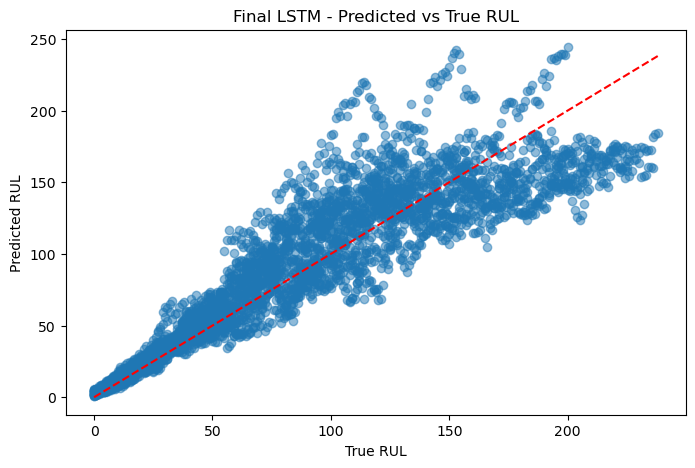

In [49]:
final_model.eval()
with torch.no_grad():
    y_val_pred = final_model(X_val_tensor).cpu().numpy()

plt.figure(figsize=(8,5))
plt.scatter(y_val_seq, y_val_pred, alpha=0.5)
plt.plot([0, max(y_val_seq)], [0, max(y_val_seq)], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Final LSTM - Predicted vs True RUL")
plt.show()

In [51]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']